In [1]:
import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')
from typing import List, Dict, Any, Tuple, Union

from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.plugins.dataset_results_processor import DatasetResultsProcessor

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

from evaluation_tools.fields.dataset_analyzer_fields import StatisticsFields
from results_analysis_tools.plugins.histogram_processor import DatasetHistogramProcessor
from results_analysis_tools.plugins.temporal_evolution_processor import TemporalEvolutionProcessor
from results_analysis_tools.plugins.synchrony_experiments_processor import SynchronyExperimentsProcessor
from results_analysis_tools.plugins.evaluation_results_processor import EvaluationResultsProcessor
from results_analysis_tools.plugins.wandb_summary_processor import WandbSummaryProcessor

from nn_model.globals import MODEL_SIZES


In [2]:
PLOTING_DESTINATION = "/home/david/source/diplomka/thesis_plots/"
EVALUATION_RESULTS_BASE = "/analysis_results"
analysis_paths = {
    EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.FULL_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.WANDB_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.WANDB_ANALYSIS.value}/results.pkl",
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.PREDICTION_ANALYSIS.value}/",
}
result_analyzer = ResultAnalyzer(analysis_paths)
all_results = result_analyzer.get_all_results
all_results.keys()


dict_keys([<EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: 'full_dataset'>, <EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: 'subset_dataset'>, <EvaluationProcessorChoices.WANDB_ANALYSIS: 'wandb_analysis'>, <EvaluationProcessorChoices.PREDICTION_ANALYSIS: 'prediction_analysis'>])

# Model Evaluation

In [3]:
# All models for which we have the evaluation results
model_batch_results = [
    ModelEvaluationRunVariant.SIMPLE_LEAKYTANH, 
    ModelEvaluationRunVariant.DNN_JOINT, 
    ModelEvaluationRunVariant.DNN_SEPARATE, 
    ModelEvaluationRunVariant.RNN_BACKPROPAGATION_5, 
    ModelEvaluationRunVariant.RNN_BACKPROPAGATION_10, 
    ModelEvaluationRunVariant.SYN_ADAPT_LGN_BACKPROPAGATION_5
]

In [4]:
# All TBPTT models 
models_tbptt = [
    ModelEvaluationRunVariant.RNN_BACKPROPAGATION_5, 
    ModelEvaluationRunVariant.RNN_BACKPROPAGATION_10, 
    ModelEvaluationRunVariant.SYN_ADAPT_LGN_BACKPROPAGATION_5
]

In [6]:
# kwargs = {"model_variant": EvaluationResultsProcessor.model_names_mapping_for_plotting[model_variant],}
filename = f"tbptt_models_forced_included_model_synchrony_curve.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TBPTT_MODELS_TEMPORAL_BEHAVIOR_TEACHER_FORCED_INCLUDED, synchrony_curve_kwargs={
    "model_variants": models_tbptt,
})
ResultsPlotter.plot(plot_data, PlottingVariants.TBPTT_MODELS_TEMPORAL_BEHAVIOR_TEACHER_FORCED_INCLUDED, save_fig=destination)

ValueError: Could not interpret value `time` for `x`. Value is a string, but `data` was not passed.

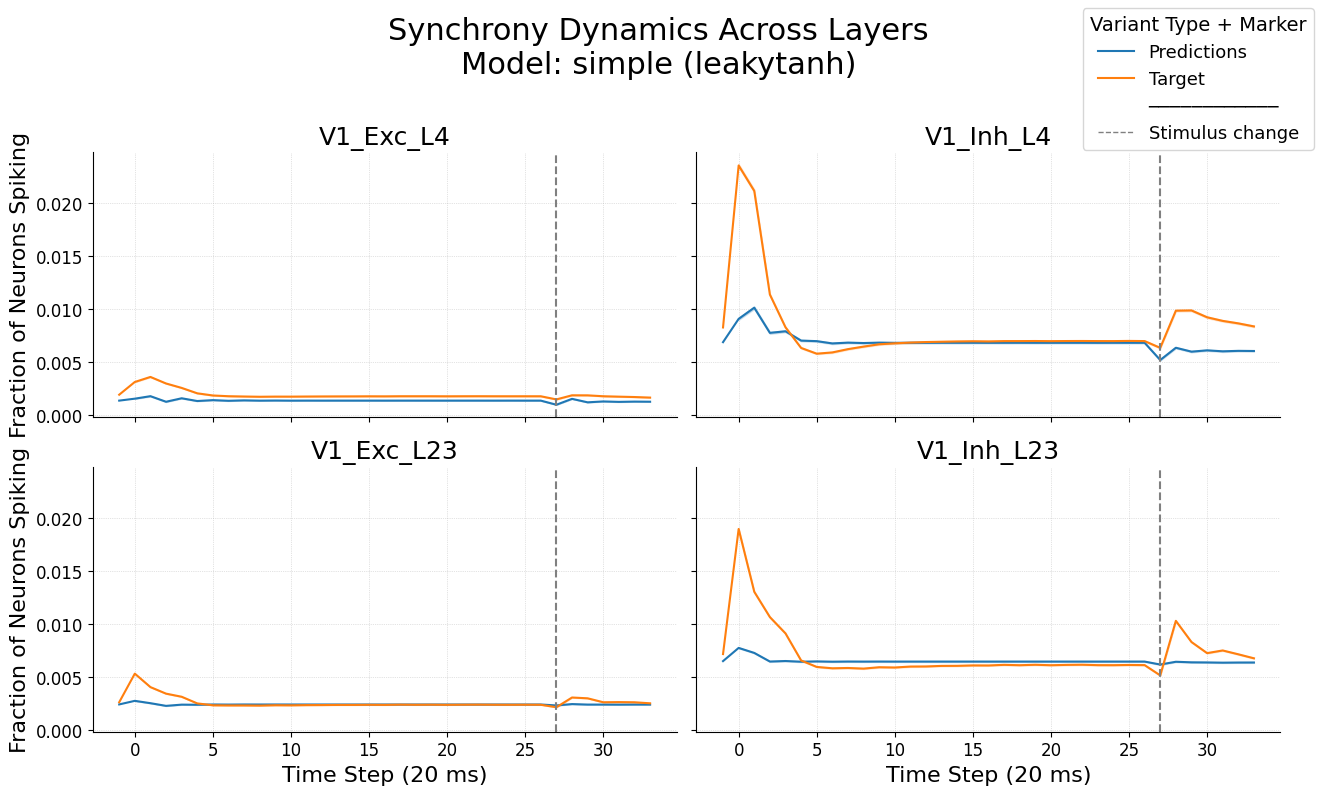

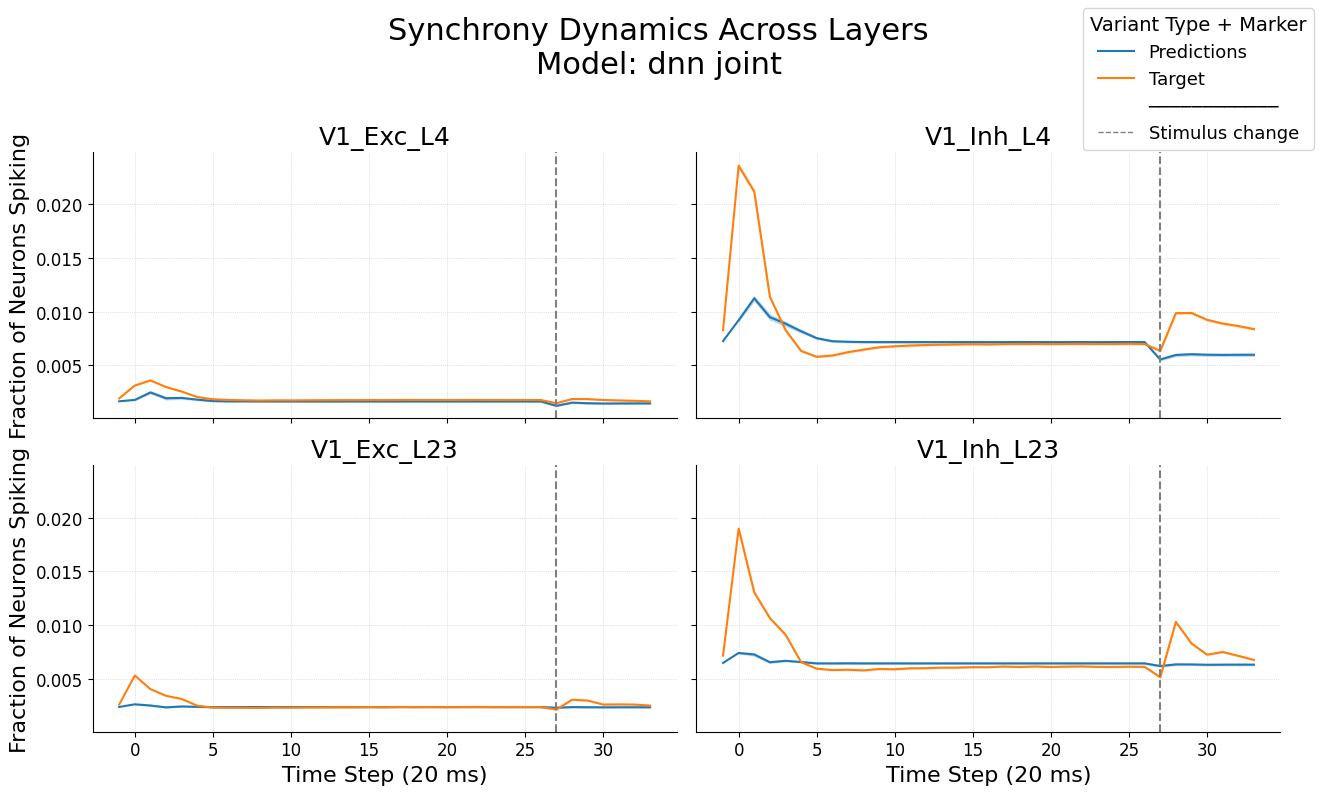

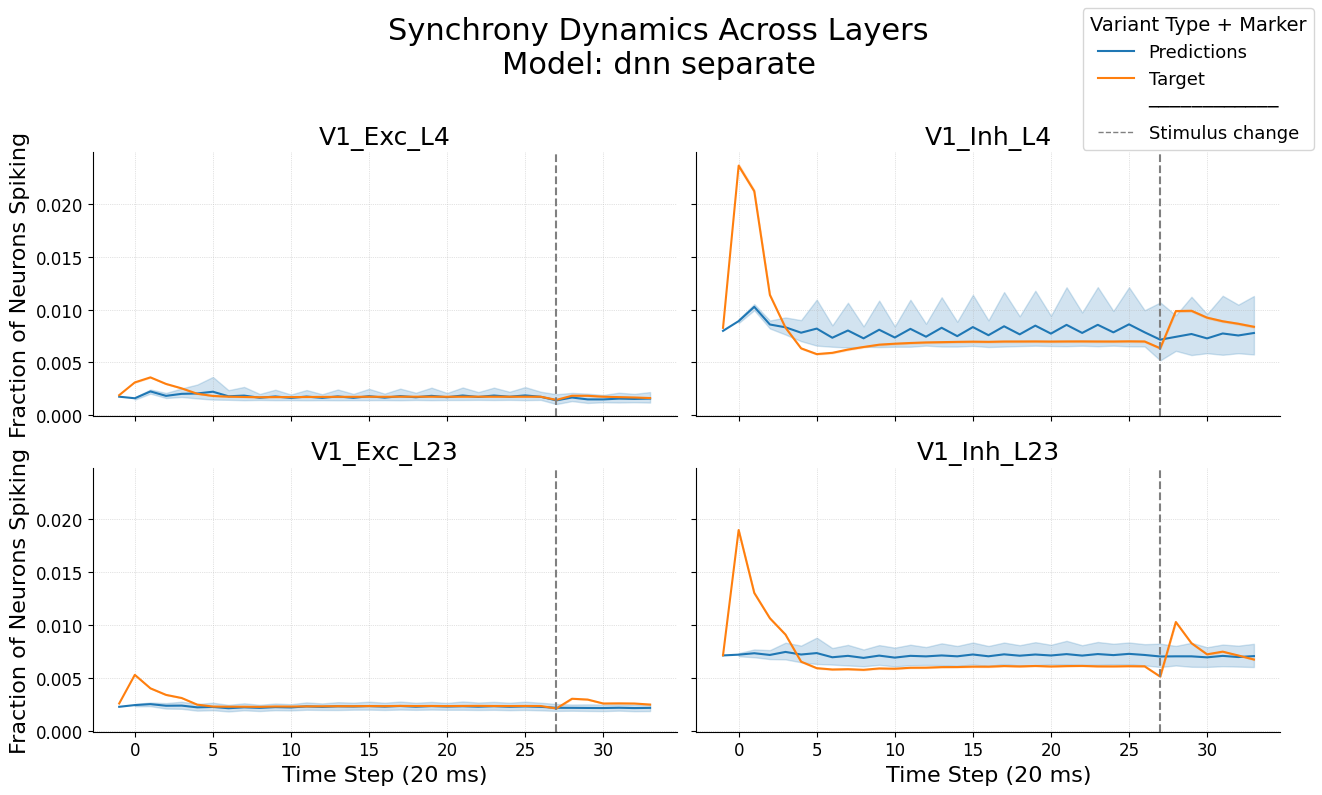

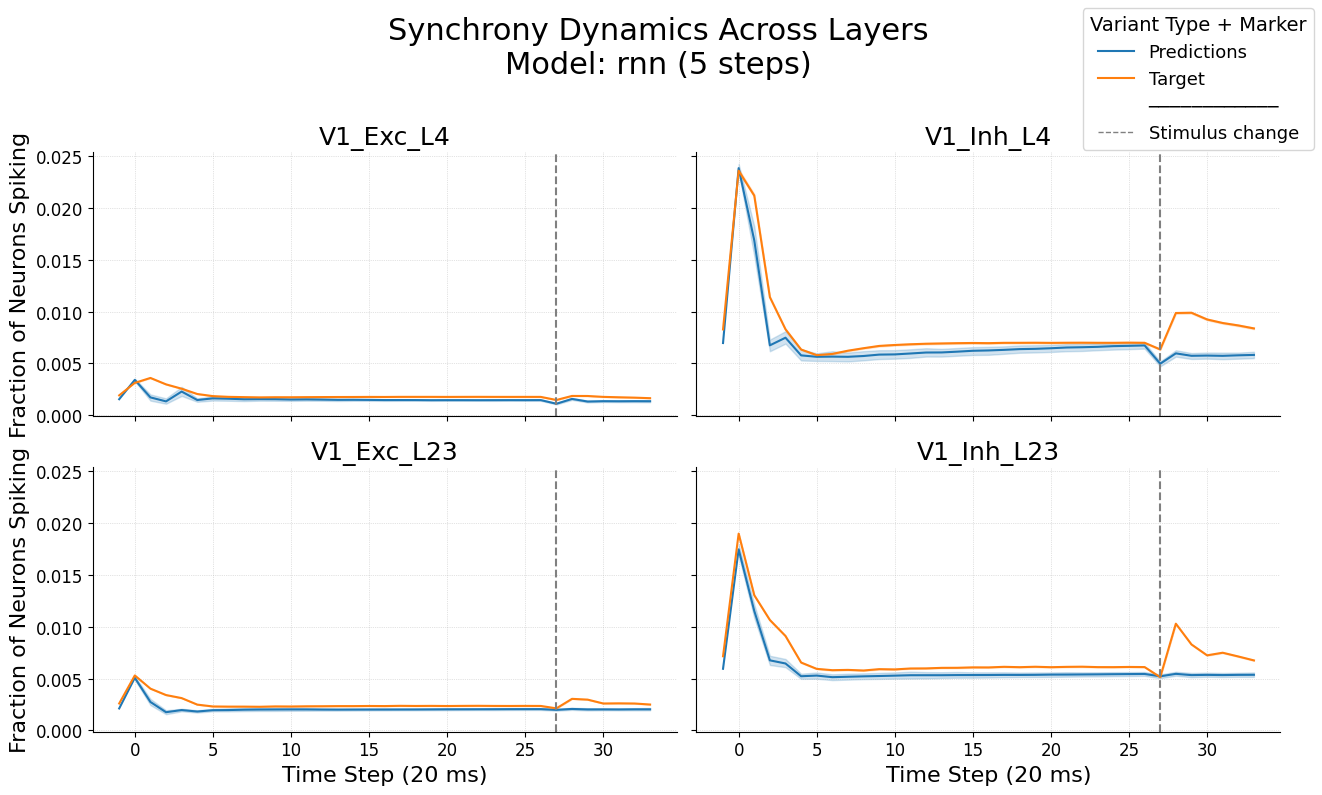

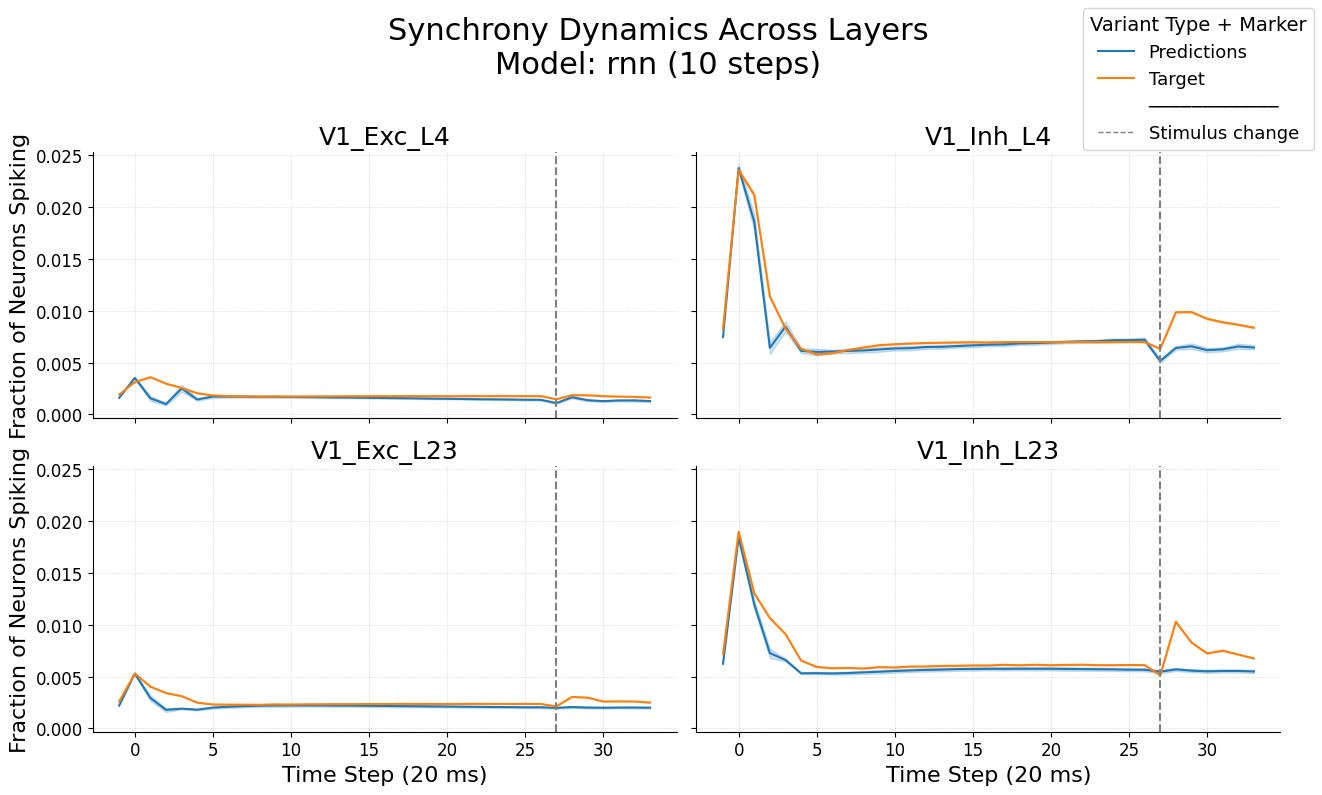

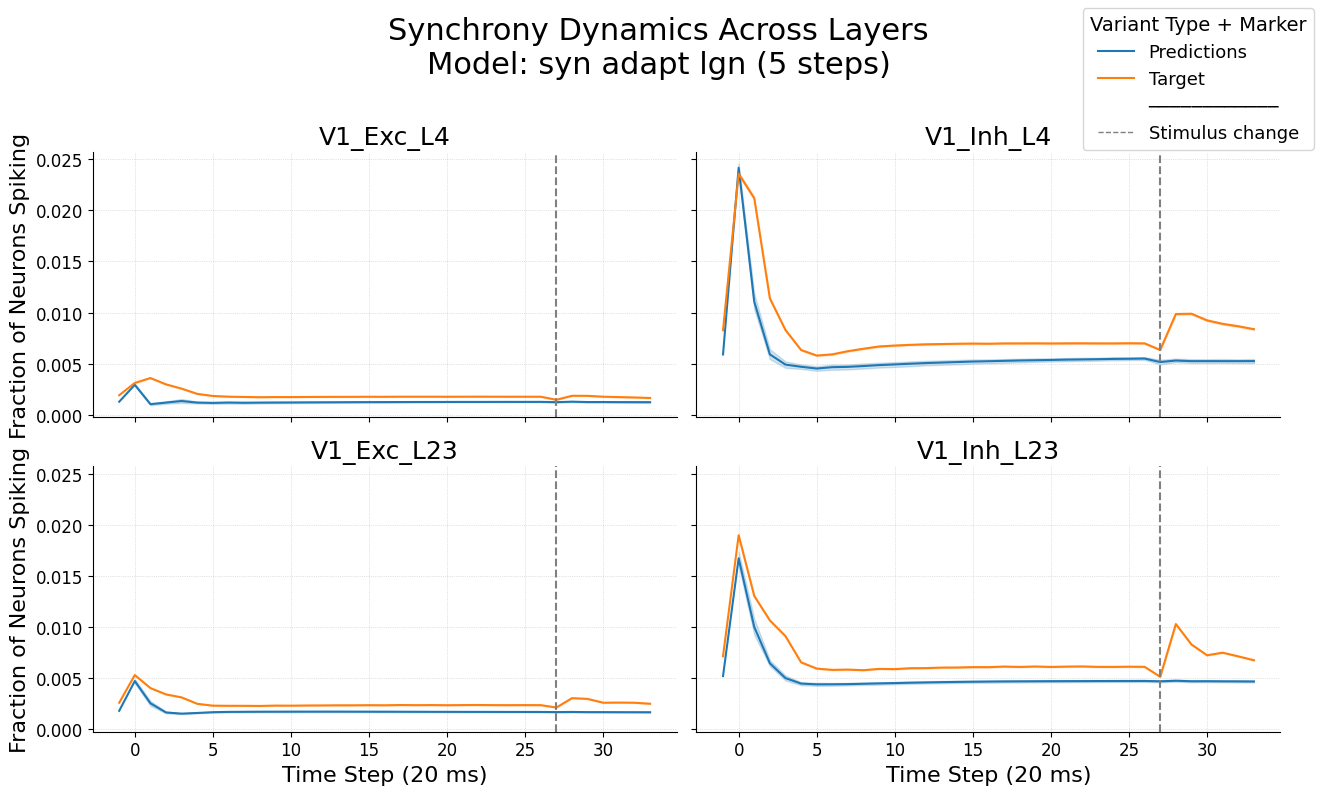

In [4]:
for model_variant in model_batch_results:
    kwargs = {"model_variant": EvaluationResultsProcessor.model_names_mapping_for_plotting[model_variant],}
    filename = f"separate_model_synchrony_curve_{model_variant.value}.pdf"
    destination = f"{PLOTING_DESTINATION}{filename}"
    plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION, synchrony_curve_kwargs={
        "model_variants": [model_variant],
    })
    ResultsPlotter.plot(plot_data, PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION, save_fig=destination, kwargs=kwargs)

## Model Setup

In [5]:
result_analyzer.get_latex_evaluation_setup()

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


'\\begin{table}\n\\caption{Setup of the models in evaluation:}\n\\label{tab:model_configs}\n\\begin{tabular}{lrrrrrrrr}\n\\toprule\nModel Variant & Epochs & lr & n-ls & n-nl & n-res & s-ls & s-nl & n-tbptt \\\\\n\\midrule\nsimple (tanh) & 10 & 0.000008 & 10 & 5 & False & 10 & 1 & 1 \\\\\nsimple (leakytanh) & 10 & 0.000075 & 10 & 5 & False & 10 & 1 & 1 \\\\\ndnn joint & 10 & 0.000010 & 10 & 5 & True & 10 & 1 & 1 \\\\\ndnn separate & 10 & 0.000010 & 10 & 5 & True & 10 & 1 & 1 \\\\\nrnn (5 steps) & 40 & 0.000030 & 10 & 3 & True & 10 & 1 & 5 \\\\\nrnn (10 steps) & 40 & 0.000030 & 10 & 3 & True & 10 & 1 & 10 \\\\\nsyn adapt lgn (5 steps) & 40 & 0.000030 & 10 & 3 & True & 10 & 2 & 5 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

## Overall Model Variant Comparison

In [6]:
result_analyzer.get_evaluation_results_summary(return_latex=False)

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(
/home/david/source/diplomka/results_analysis_tools/plugins/wandb_summary_processor.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["model_variant", "Correlation Type"])["Correlation Value"]


,model_variant,N-CC (mean),P-CC (mean),N-CC (std),P-CC (std)
5,rnn (10 steps),0.9212,0.7500,0.0084,0.0082
4,rnn (5 steps),0.9176,0.7471,0.0103,0.0089
6,syn adapt lgn (5 steps),0.8935,0.7275,0.0043,0.0042
2,dnn joint,0.8803,0.7168,0.0021,0.0034
1,simple (leakytanh),0.8778,0.7147,0.0014,0.0032
3,dnn separate,0.8430,0.6864,0.0940,0.0766
0,simple (tanh),0.2767,0.2252,0.0400,0.0321


/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


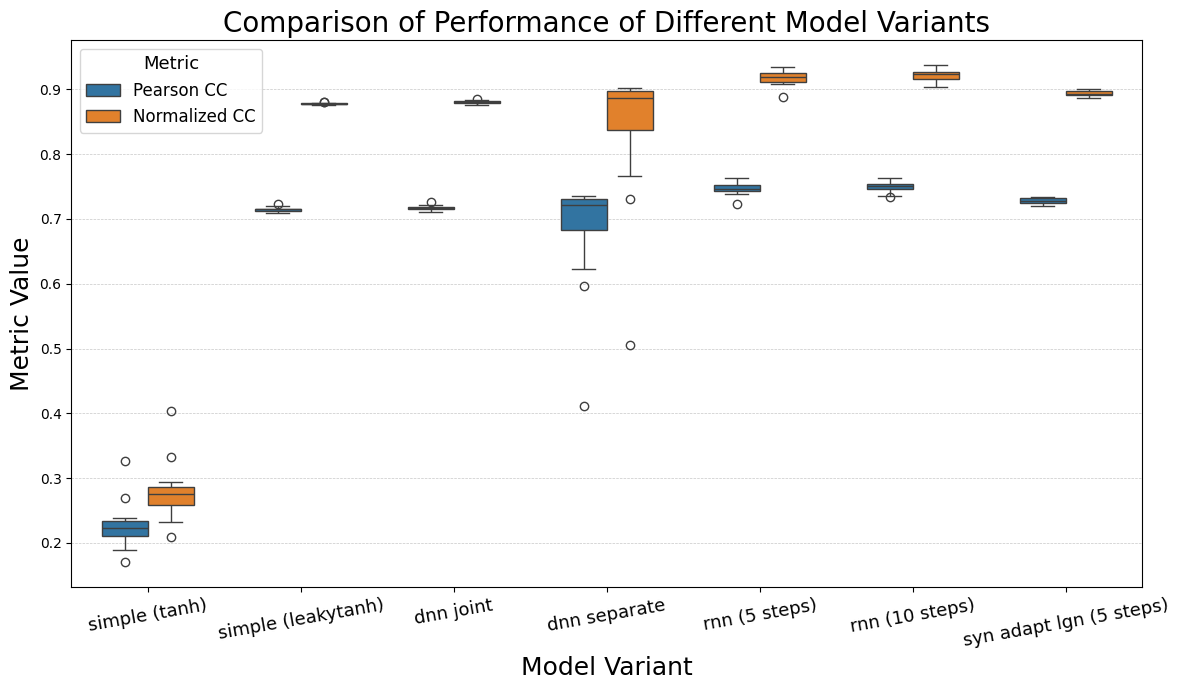

In [7]:
filename = f"model_types_correlation_comparison.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.MODEL_TYPES_CORRELATION_COMPARISON)
ResultsPlotter.plot(plot_data, PlottingVariants.MODEL_TYPES_CORRELATION_COMPARISON, save_fig=destination, kwargs={})

Model normalized CC p-values

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


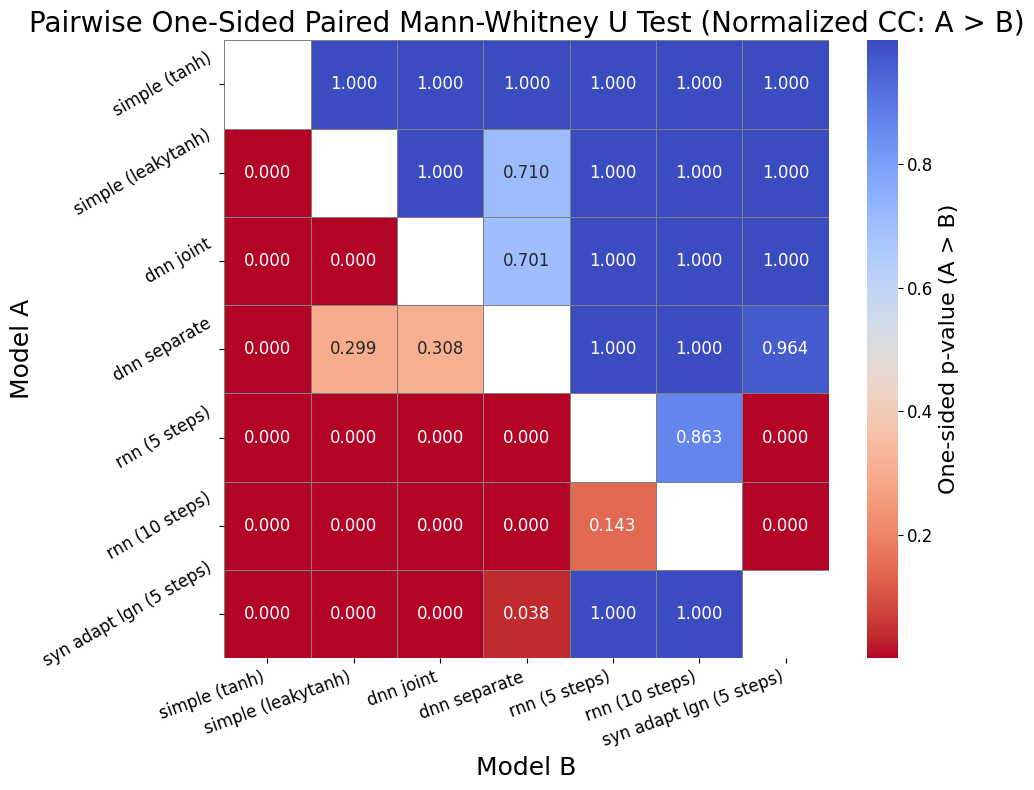

In [8]:
filename = f"model_types_p_value_heatmap_cc_norm.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.MODEL_TYPES_P_VALUES_HEATMAP)
ResultsPlotter.plot(plot_data, PlottingVariants.MODEL_TYPES_P_VALUES_HEATMAP, save_fig=destination, kwargs={})

# Full Dataset Analysis

## Time Bin Spike Counts
This part of code shows how to plot the distribution of spike counts across all time bins and how to write the exact ratios.

In [9]:
result_analyzer.get_mean_spike_counts(False,).head(5)

,time_step,spike_count_bin,normalized_density
0,1,0,0.9944
1,1,1,0.0056
2,1,2,0.0000
3,1,3,0.0000
4,1,4,0.0000


In [10]:
result_analyzer.get_mean_spike_counts(True).head(5)

,time_step,spike_count_bin,normalized_density
0,1,0,0.9944
1,1,1,0.0056
2,1,2,0.0000
3,1,3,0.0000
4,1,4,0.0000


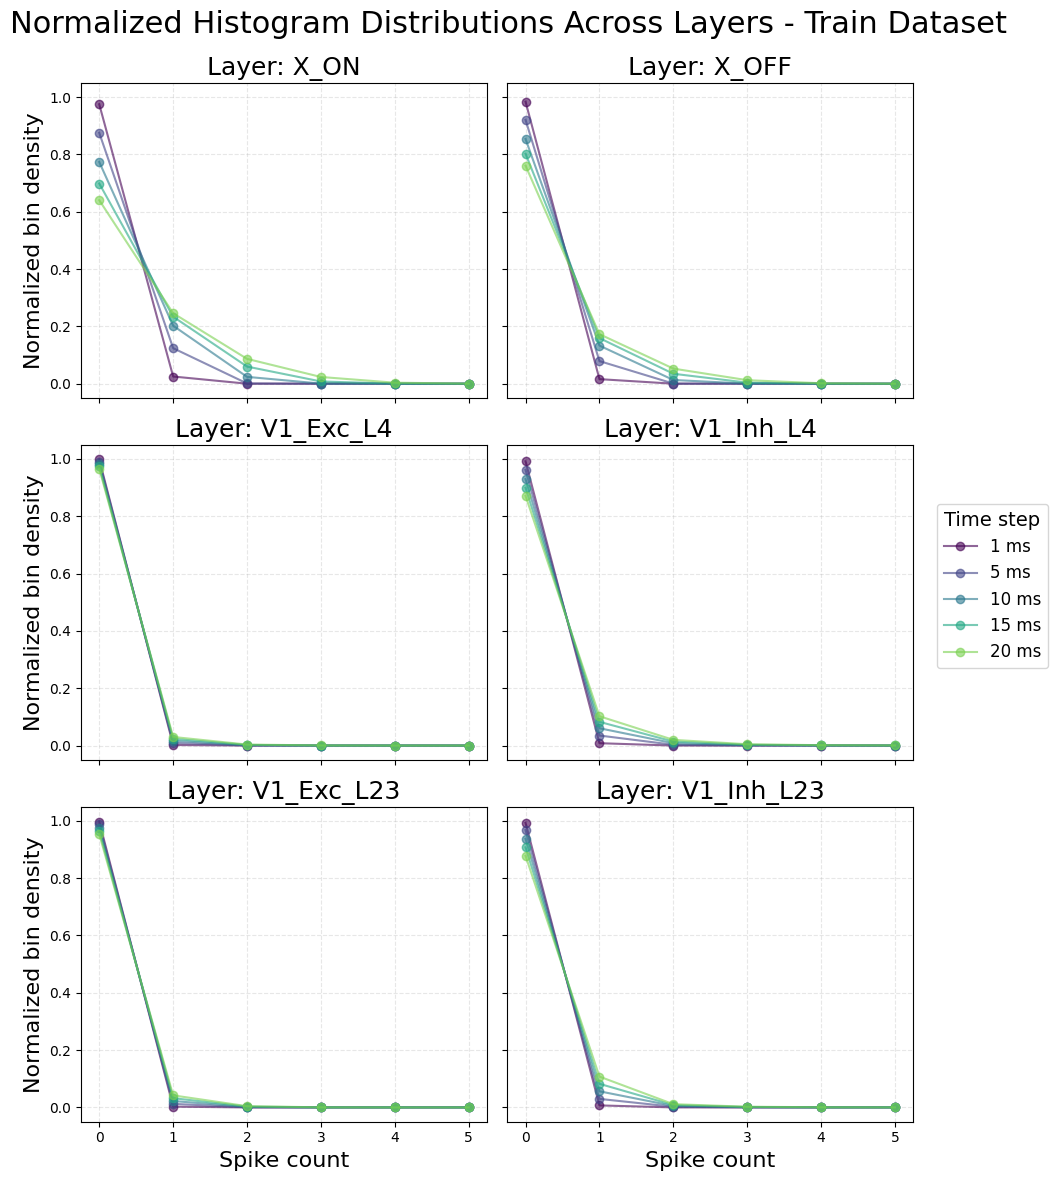

In [11]:
is_test = False
kwargs = {"is_test": is_test}
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, save_fig=destination, kwargs=kwargs)

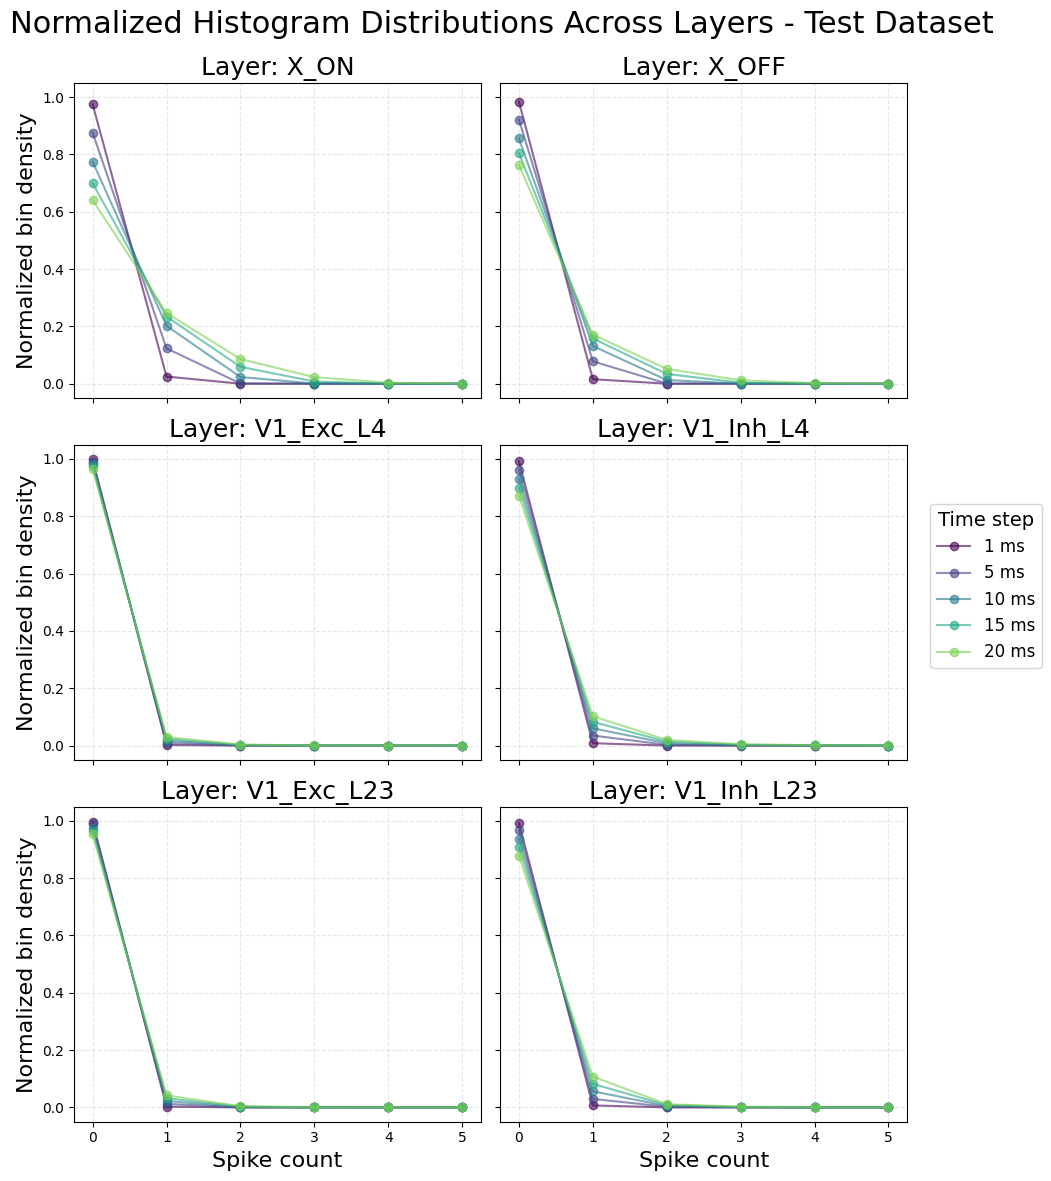

In [12]:
is_test = True
kwargs = {"is_test": is_test}
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, save_fig=destination, kwargs=kwargs)

## Temporal Distribution of Spikes

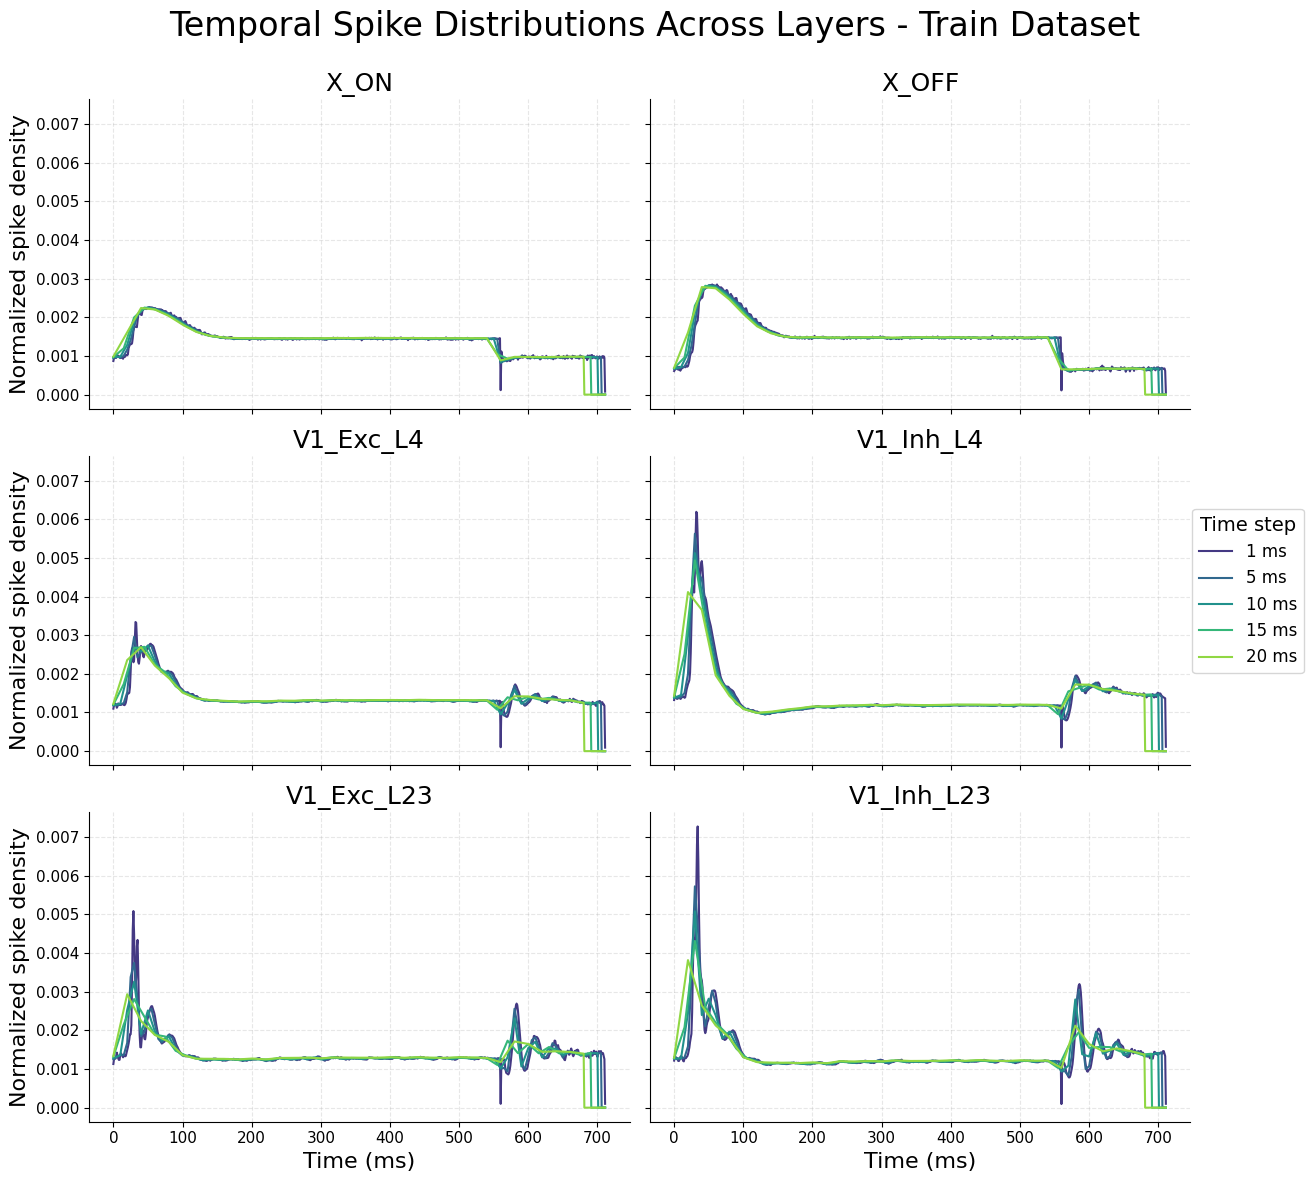

In [13]:
is_test = False
kwargs = {"is_test": is_test}
filename = f"temporal_spike_distribution_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, kwargs=kwargs)

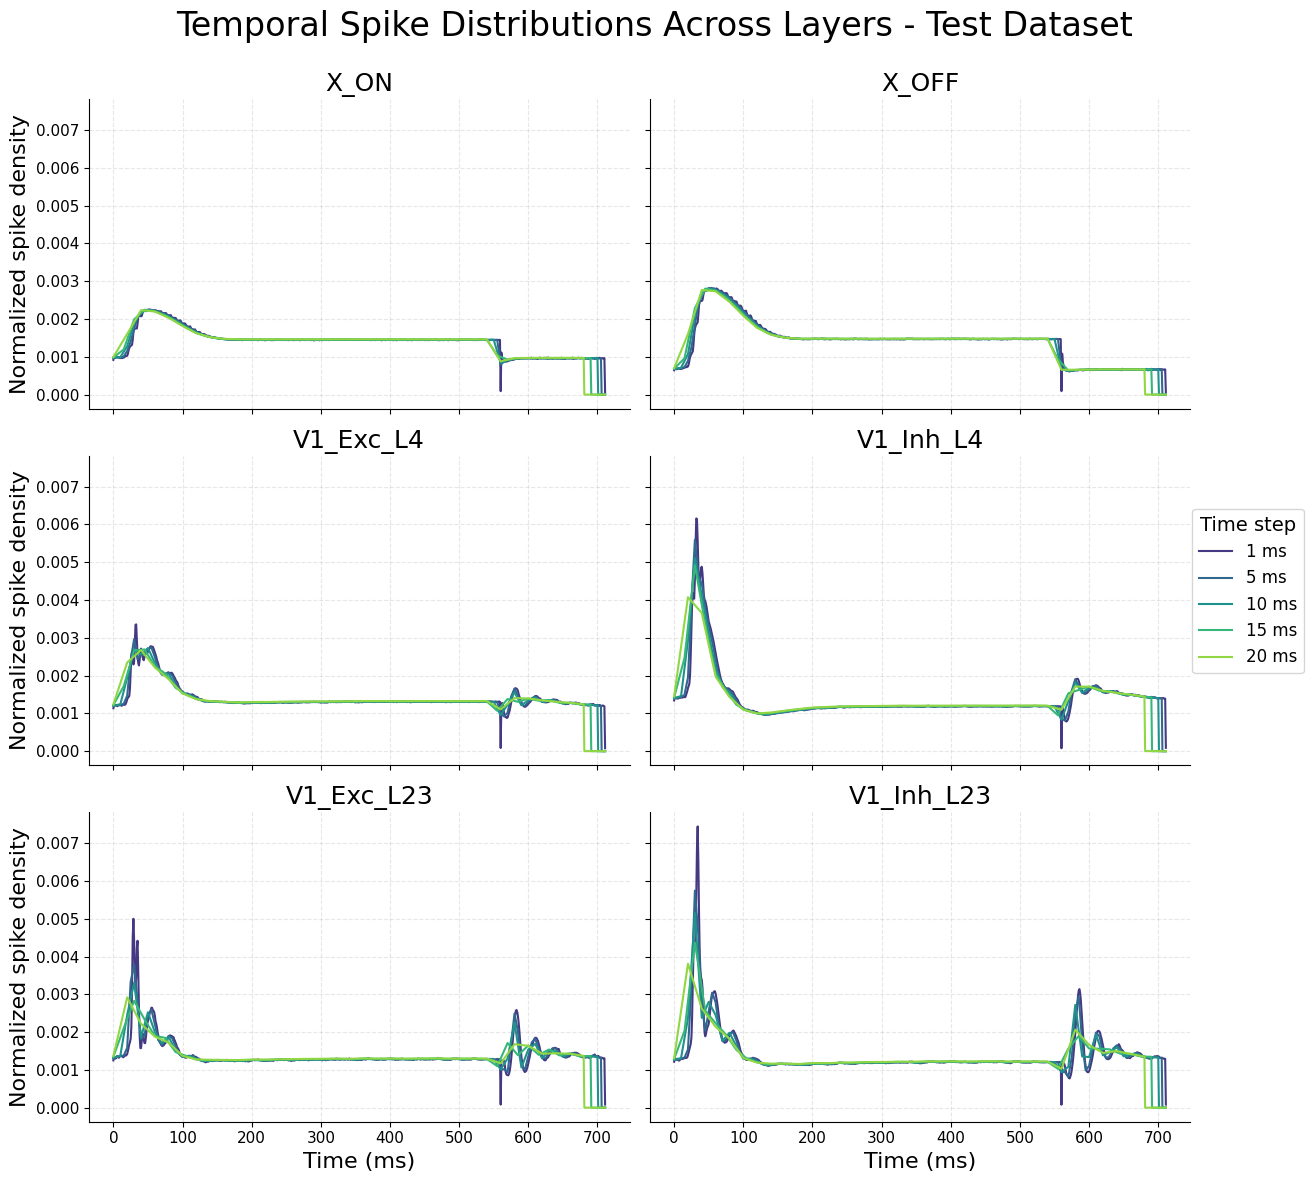

In [14]:
is_test = True
kwargs = {"is_test": is_test}
filename = f"temporal_spike_distribution_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, kwargs=kwargs)

/home/david/source/diplomka/results_analysis_tools/plotting/temporal_spike_distribution.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


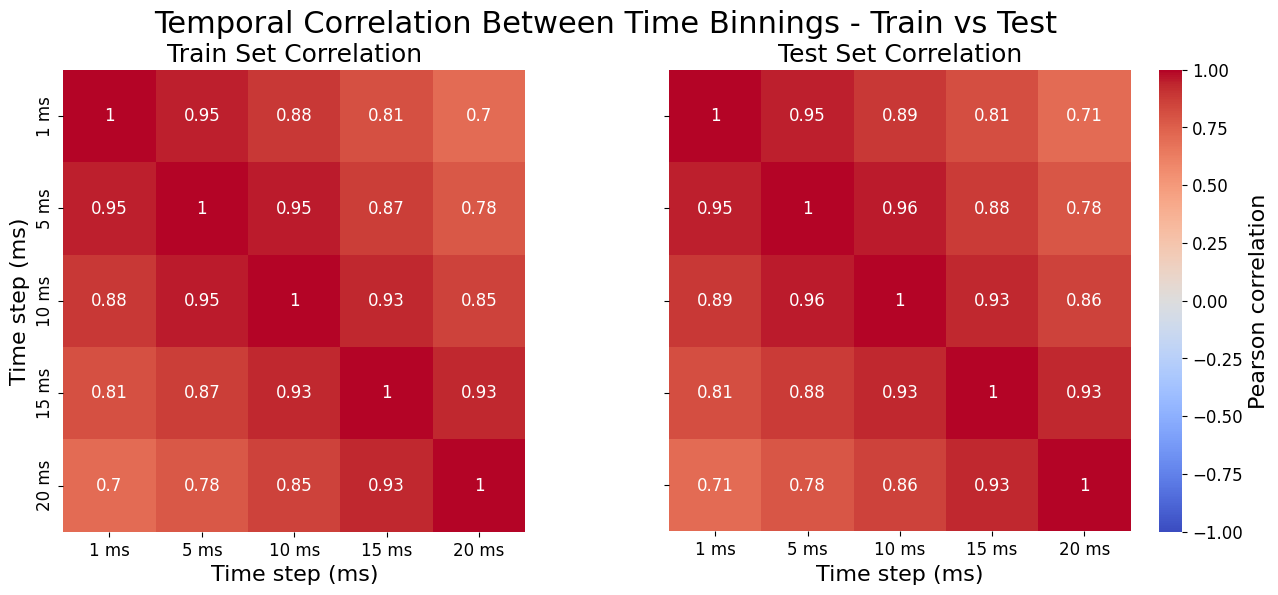

In [15]:
filename = "temporal_correlation_time_bin_size.pdf"
kwargs = {"is_test": is_test}
destination = f"{PLOTING_DESTINATION}{filename}"
train_corr = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, is_test=False)
test_corr = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, is_test=True)
ResultsPlotter.plot((train_corr, test_corr), PlottingVariants.FULL_CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, save_fig=destination, kwargs=kwargs)

## Synchrony 

Plotting of the synchrony boxplot across different time bin sizes.

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


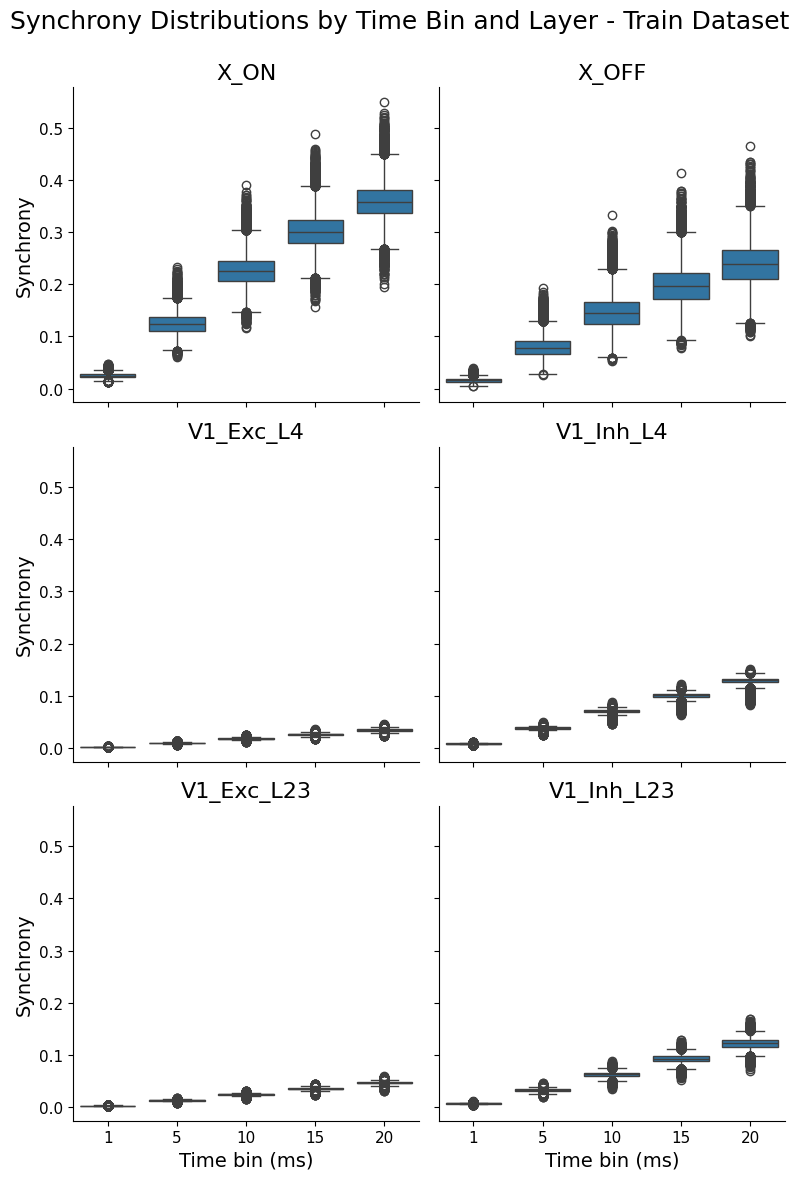

In [16]:
is_test = False
kwargs = {"is_test": is_test}
filename = f"synchrony_boxplot_time_bins_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_SYNCHRONY_TIME_BINS, save_fig=destination, kwargs=kwargs)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


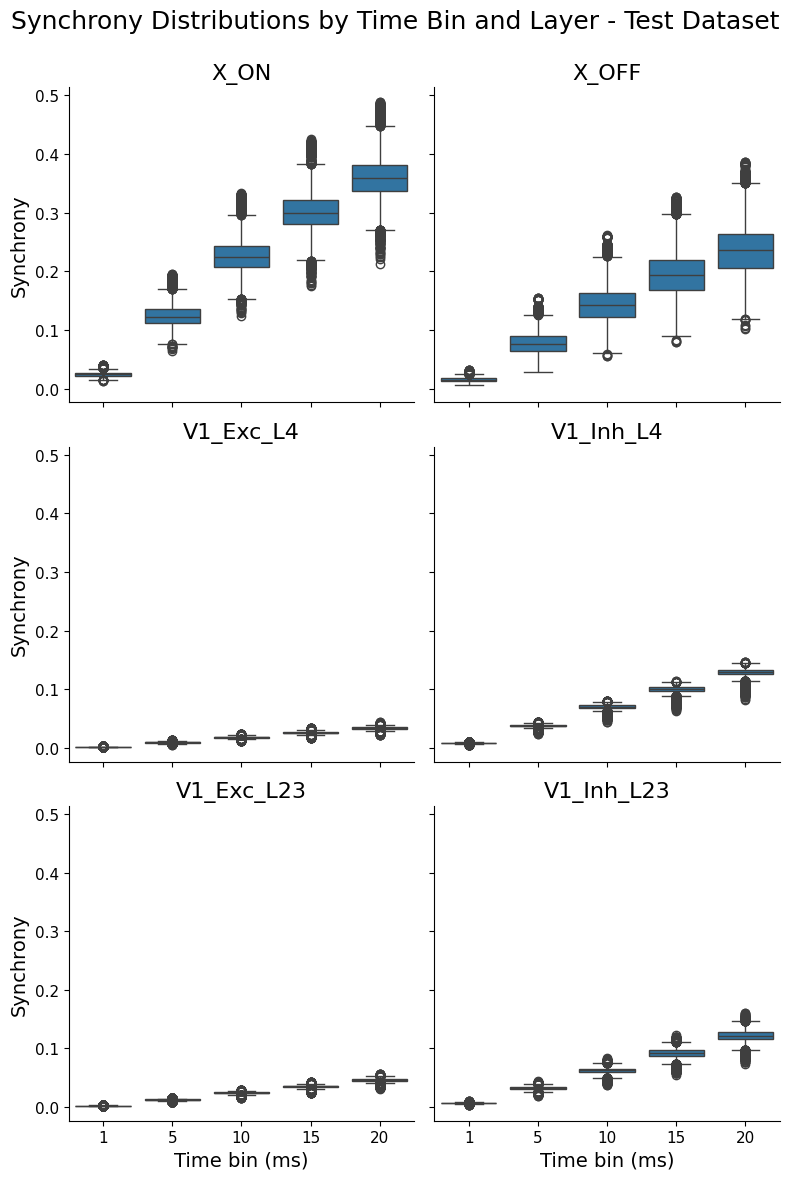

In [17]:
is_test = True
kwargs = {"is_test": is_test}
filename = f"synchrony_boxplot_time_bins_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_SYNCHRONY_TIME_BINS, save_fig=destination, kwargs=kwargs)

In [18]:
result_analyzer.get_synchrony_summary(is_test=False, return_latex=False)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


,time_step,mean,variance
0,1,0.0101,0.0001
1,5,0.0494,0.0018
2,10,0.0912,0.0057
3,15,0.1256,0.0098
4,20,0.1551,0.0134


In [19]:
result_analyzer.get_synchrony_summary(is_test=True, return_latex=False)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


,time_step,mean,variance
0,1,0.0101,0.0001
1,5,0.0491,0.0017
2,10,0.0908,0.0057
3,15,0.1250,0.0097
4,20,0.1545,0.0133


# Subset Dataset Analysis


## Time Bin Spike Counts

In [20]:
is_test=False
result_analyzer.get_mean_spike_counts(is_test, process_subset=True)

,spike_count_bin,full_density,subset_mean,subset_std
0,0,0.9105,0.9102,0.0004
1,1,0.0710,0.0712,0.0003
2,2,0.0147,0.0148,0.0001
3,3,0.0032,0.0032,0.0000
4,4,0.0005,0.0005,0.0000
5,5,0.0001,0.0001,0.0000


## Temporal behavior comparison of Subset and Full dataset

/home/david/source/diplomka/results_analysis_tools/plugins/temporal_evolution_processor.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df.groupby(["layer", "subset_id"])
/home/david/source/diplomka/results_analysis_tools/plotting/temporal_spike_distribution.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g.axes.flatten(), combined_df.groupby("layer")


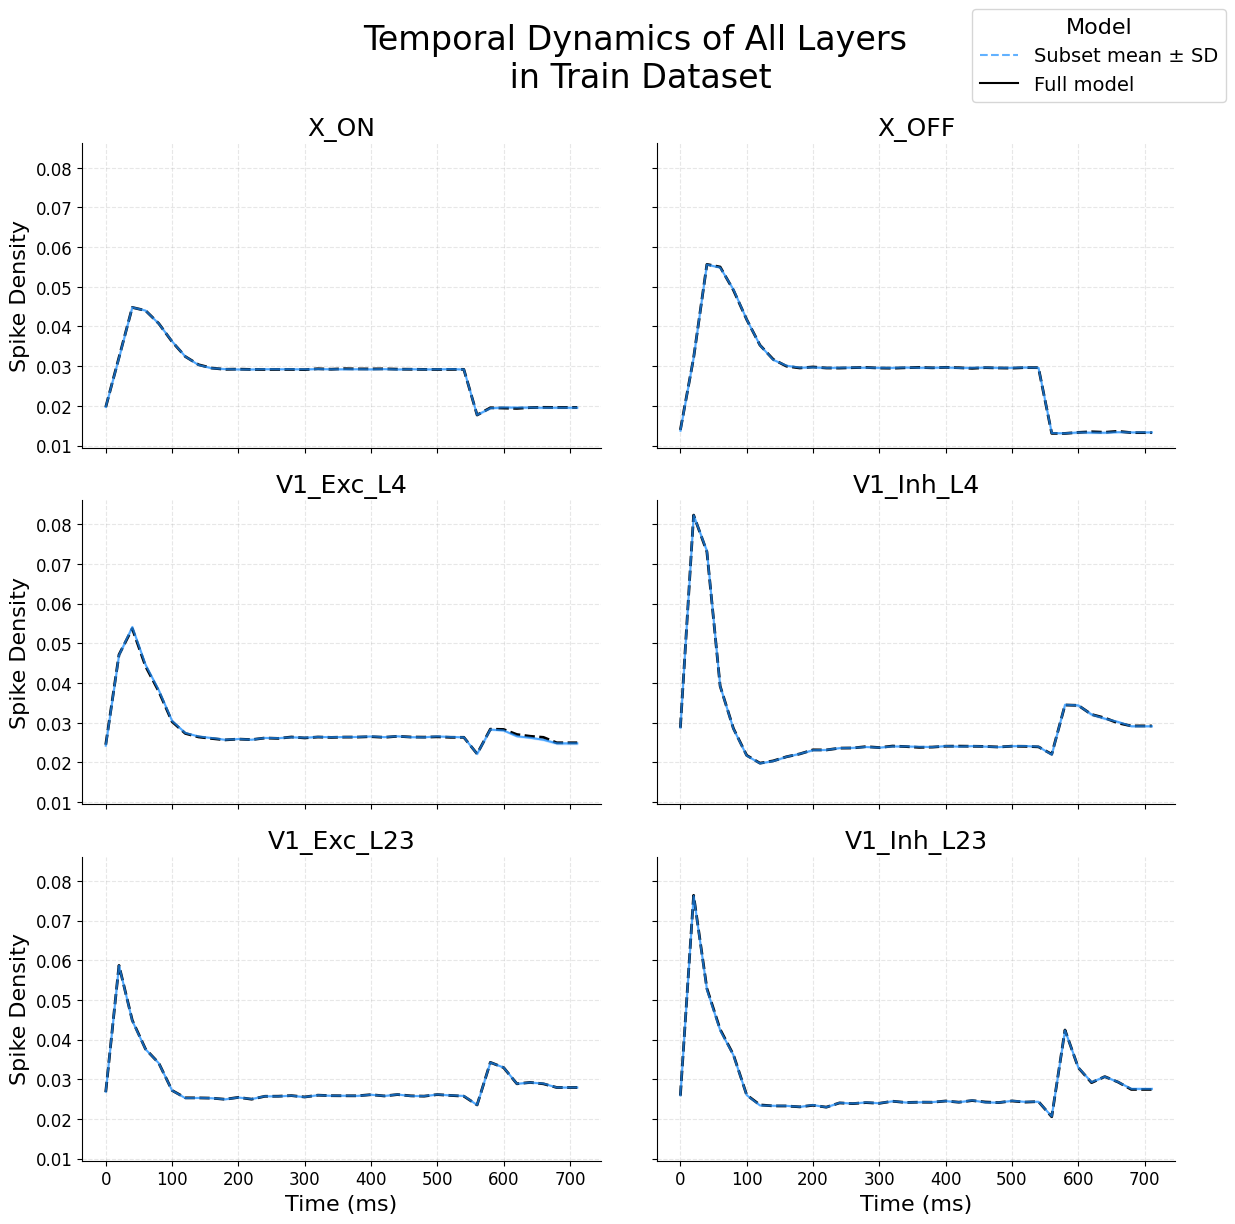

In [21]:
is_test = False
kwargs = {"is_test": is_test}
filename = f"temporal_distribution_subset_vs_full_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SUBSET_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.SUBSET_TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, kwargs=kwargs)

## Synchrony Comparison

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')
Index(['subset_id', 'layer', 'statistics_type', 'values'], dtype='object')


/home/david/source/diplomka/results_analysis_tools/plotting/synchrony_comparison.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strip_df = df.groupby(["layer", "model_type"]).sample(


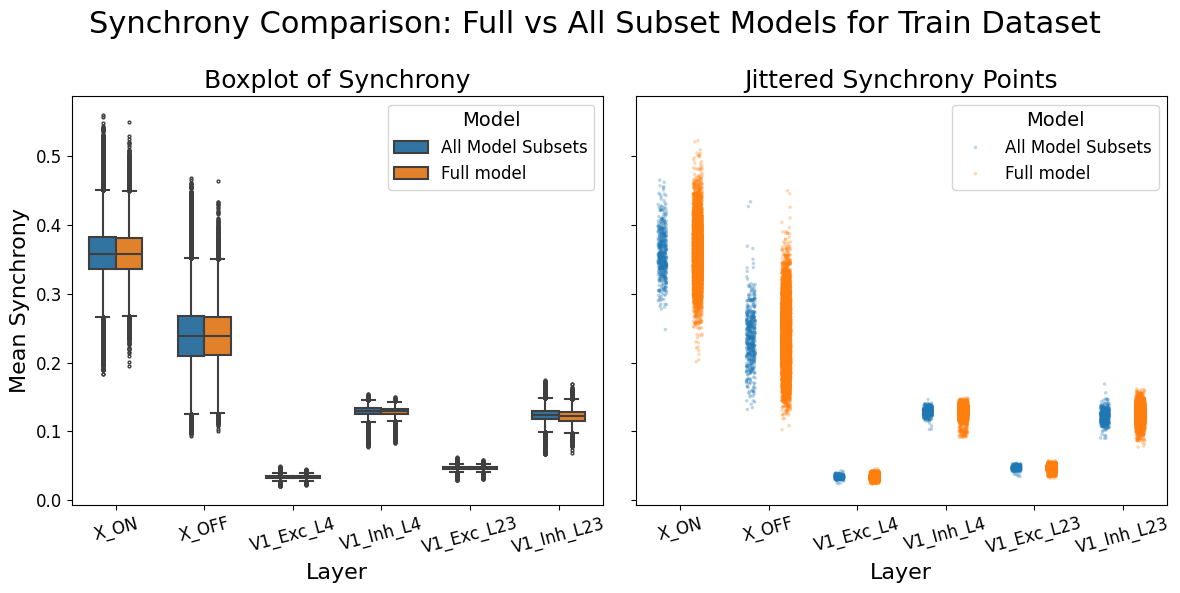

In [22]:
is_test = False
kwargs = {"is_test": is_test}
filename = f"synchrony_comparison_subset_full_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SUBSET_SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.SUBSET_SYNCHRONY_TIME_BINS, save_fig=destination, kwargs=kwargs)